# Decision Tree Classifier — Wine Quality Dataset (From Scratch)

This notebook demonstrates a **Decision Tree classifier implemented entirely from scratch**
using the `rice_ml` package. No `sklearn` models are used.

We will:

- Load and inspect the Wine Quality dataset
- Perform exploratory data analysis (EDA)
- Construct a binary classification target
- Train a custom Decision Tree classifier
- Evaluate model performance
- Visualize decision regions using PCA

This notebook mirrors a standard supervised learning workflow and emphasizes
both **interpretability** and **mathematical intuition**

## Understanding Decision Trees — Intuition and Mathematics

A **Decision Tree** is a supervised learning model that predicts outcomes by
recursively splitting the feature space into smaller, more homogeneous regions.

Each internal node applies a rule of the form:

- Is `feature_j ≤ threshold`?

Each leaf node stores a class probability distribution and predicts the
most likely class.

### Intuition

Decision Trees attempt to create regions where the target variable is
as **pure** as possible.

For the wine dataset, intuitive rules might include:

- Higher alcohol → better quality
- Higher volatile acidity → worse quality
- Higher sulphates → better quality

These rules are **learned automatically** by the tree.


### Gini Impurity

To measure how mixed a node is, we use **Gini impurity**:

$$
G = 1 - \sum_{c} p(c)^2
$$

where $p(c)$ is the proportion of class $c$ in the node.


- Gini = 0 → pure node
- Gini near 0.5 → mixed classes

### How Splits Are Chosen

At each node, the tree evaluates all possible feature–threshold pairs and
chooses the split that **minimizes the weighted Gini impurity** of the children.

This greedy process is repeated recursively until stopping criteria are met.


## Dataset Overview: Wine Quality (Red)

All features in the Wine Quality dataset are continuous physicochemical
measurements. The dataset contains no missing values. The original target variable quality is an integer score from 0–10.

| Feature | Type | Description |
|-------|------|-------------|
| fixed acidity | Continuous | Tartaric acid concentration |
| volatile acidity | Continuous | Acetic acid concentration |
| citric acid | Continuous | Citric acid content |
| residual sugar | Continuous | Remaining sugar after fermentation |
| chlorides | Continuous | Salt content |
| free sulfur dioxide | Continuous | Free SO₂ concentration |
| total sulfur dioxide | Continuous | Total SO₂ concentration |
| density | Continuous | Wine density |
| pH | Continuous | Acidity level |
| sulphates | Continuous | Potassium sulphate content |
| alcohol | Continuous | Alcohol percentage |


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploratory Data Analysis (EDA)

Before modeling, we explore:

- Dataset shape
- Distribution of wine quality scores
- Feature behavior by class
- Correlation structure

Although Decision Trees do not require feature scaling,
EDA helps interpret which splits the tree may learn.


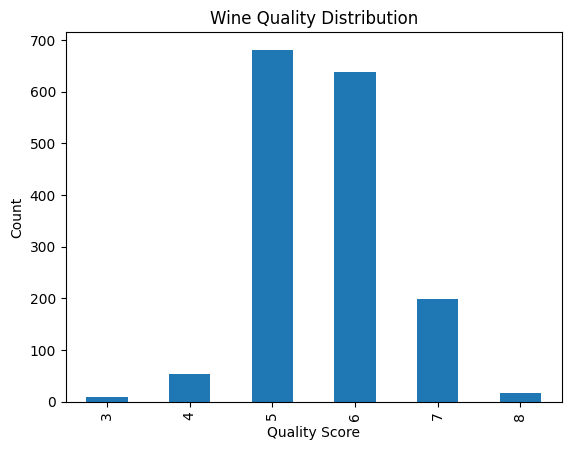

In [9]:
# Target Distribution

df["quality"].value_counts().sort_index().plot(kind="bar")
plt.title("Wine Quality Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()

### Univariate Distribution Plot: 

This histogram shows the marginal distribution of alcohol content.
Higher alcohol values are associated with higher wine quality, which
suggests that alcohol may be a strong splitting feature for the tree.


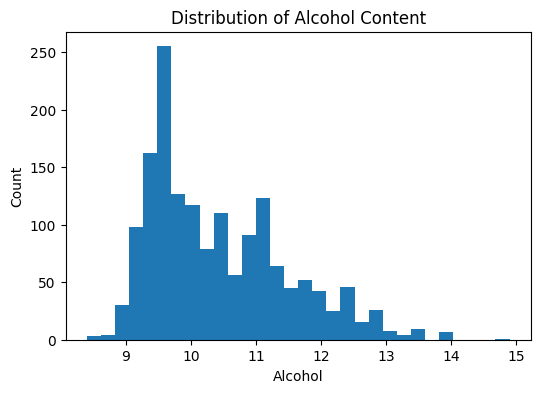

In [10]:
plt.figure(figsize=(6, 4))
plt.hist(df["alcohol"], bins=30)
plt.title("Distribution of Alcohol Content")
plt.xlabel("Alcohol")
plt.ylabel("Count")
plt.show()


## Binary Classification Target

To simplify modeling, we convert wine quality into a binary target:

- **1 (Good wine)**: quality ≥ 6
- **0 (Bad wine)**: quality < 6

This creates an interpretable binary classification problem
well-suited for Decision Trees.

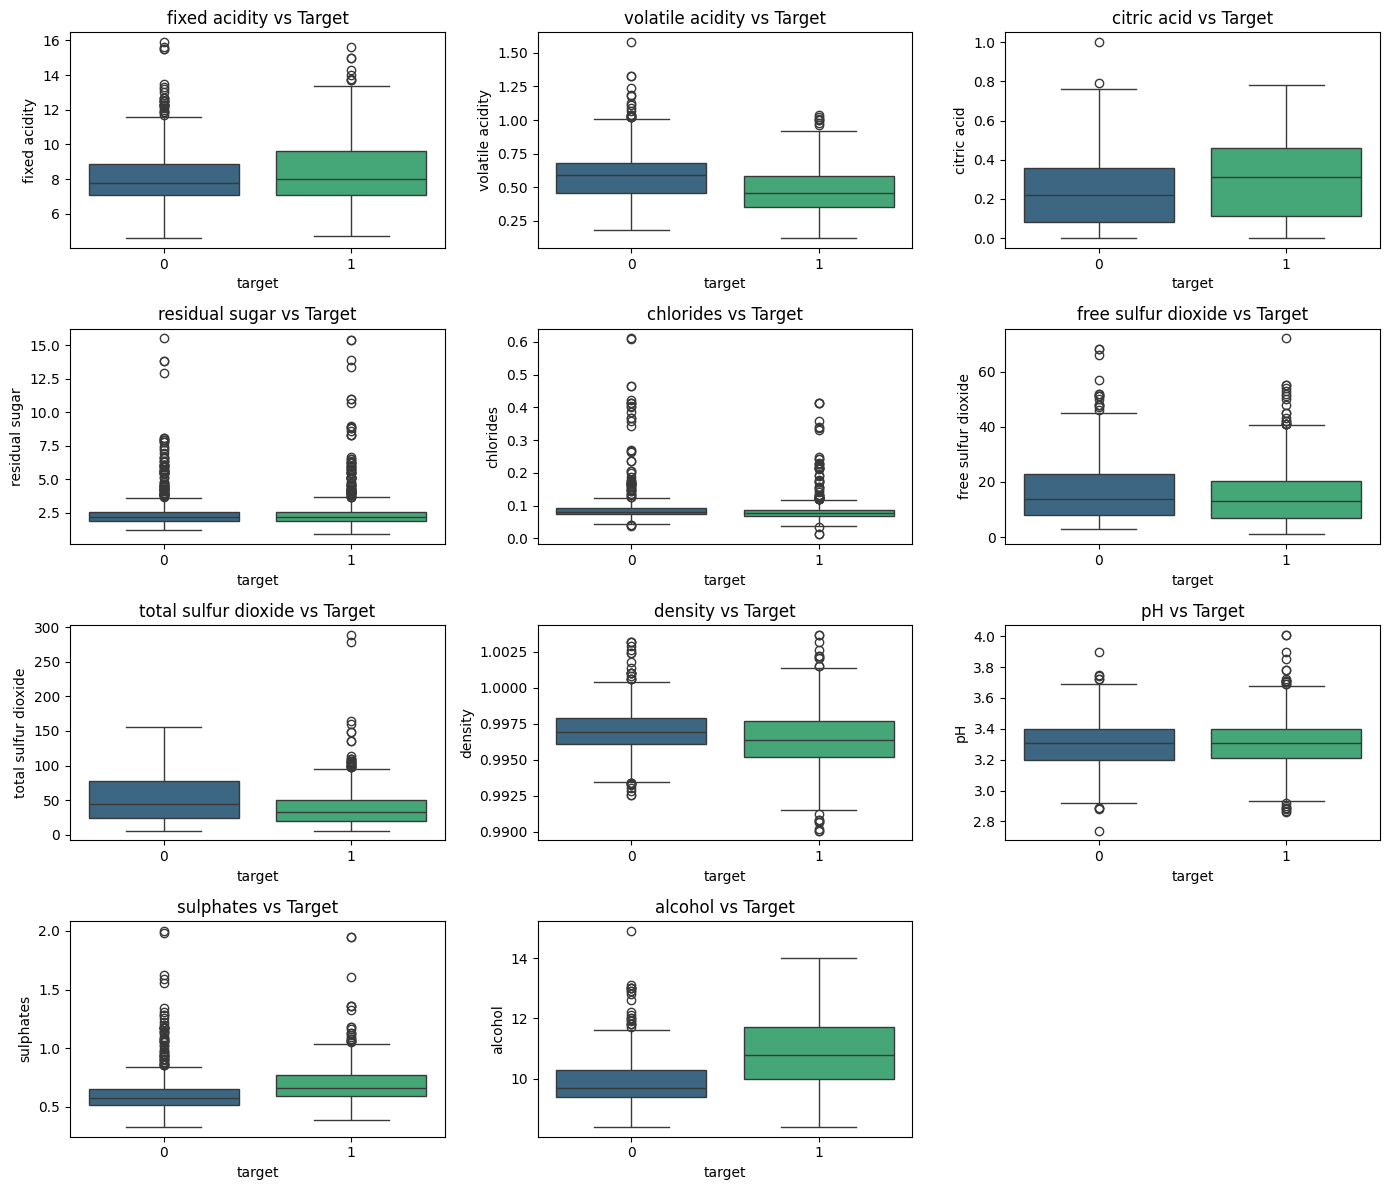

In [11]:
# Feature vs. Target Visualization

df["target"] = (df["quality"] >= 6).astype(int)

plt.figure(figsize=(14, 12))
for i, col in enumerate(df.drop(columns=["quality", "target"]).columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(
        data=df,
        x="target",
        y=col,
        hue="target",
        dodge=False,
        palette="viridis",
        legend=False
    )
    plt.title(f"{col} vs Target")
plt.tight_layout()
plt.show()


### Correlation Structure

Decision Trees are insensitive to correlation,
but understanding redundancy among features provides insight into the dataset.


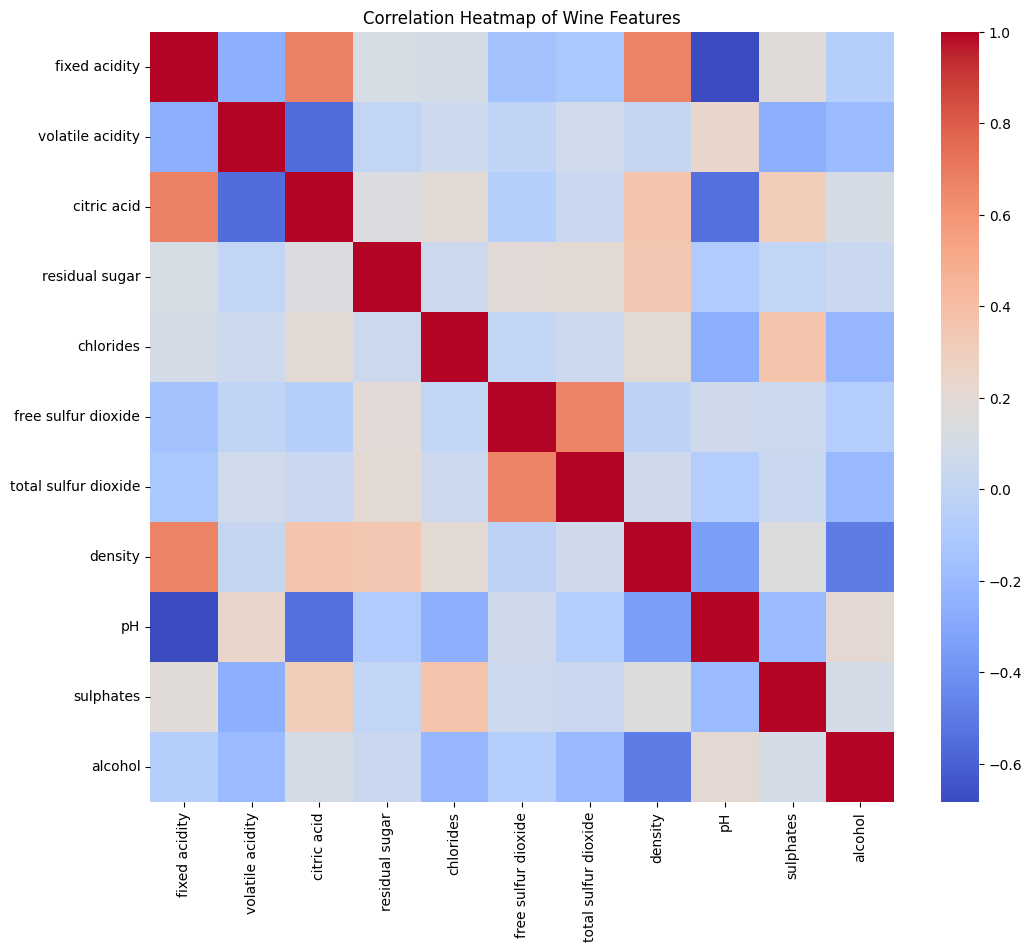

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    df.drop(columns=["quality", "target"]).corr(),
    cmap="coolwarm",
    annot=False
)
plt.title("Correlation Heatmap of Wine Features")
plt.show()

## Preprocessing

We construct:

- Feature matrix $X \in \mathbb{R}^{n \times d}$
- Target vector $y \in \{0,1\}^n$

We then split the dataset into training and test sets using
our custom `train_test_split` function.


In [13]:
# Train / Test Split

from rice_ml.processing.preprocessing import train_test_split

X = df.drop(columns=["quality", "target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape


((1200, 11), (399, 11))

## Training the Decision Tree

We train a Decision Tree classifier with a **maximum depth constraint**.

Limiting depth helps control overfitting by restricting
how many recursive splits the tree can make.


In [14]:
from rice_ml.supervised_learning.decision_tree import DecisionTree

tree = DecisionTree(max_depth=4)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
test_acc = tree.score(X_test, y_test)

train_acc, test_acc


(0.775, 0.7017543859649122)

### Interpretation

- Training accuracy is higher than test accuracy, indicating mild overfitting
- The depth constraint provides a reasonable bias–variance tradeoff
- The model learns meaningful threshold-based rules from the data


## PCA for Visualization

Because the dataset has 11 features, we cannot visualize
decision boundaries directly.

We use **Principal Component Analysis (PCA)** to project the data
into two dimensions **for visualization only**.

PCA finds orthogonal directions of maximum variance:

$$
X_{\text{PCA}} = X W
$$

The Decision Tree itself is still trained in the original feature space.


In [15]:
# PCA and 2D Tree

from rice_ml.unsupervised_learning.pca import PCA

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

tree_2d = DecisionTree(max_depth=4)
tree_2d.fit(X_train_2d, y_train)


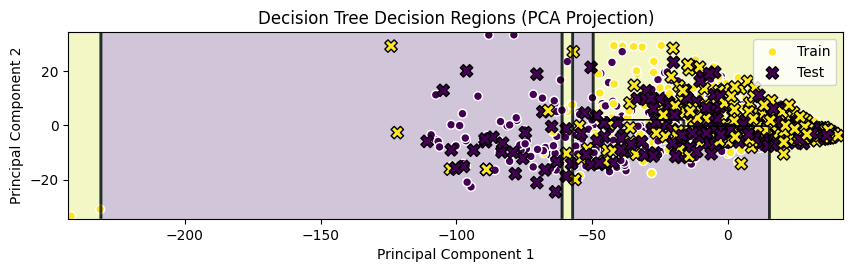

In [16]:
# Decision Boundary Visualization

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = tree_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_aspect("equal", "box")

plt.contourf(xx, yy, Z, alpha=0.25, cmap="viridis")
plt.contour(xx, yy, Z, colors="black", linewidths=0.3)

plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1],
            c=y_train, cmap="viridis", edgecolor="white", s=40, label="Train")

plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
            c=y_test, cmap="viridis", edgecolor="black", s=80, marker="X", label="Test")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Decision Tree Decision Regions (PCA Projection)")
plt.legend()
plt.show()


### Interpretation of the PCA Decision Boundary Visualization

This visualization shows the decision regions of the trained Decision Tree after projecting the data into two dimensions using PCA. Several important observations can be made:

1. Separation along the first principal component:
Most of the class separation occurs along Principal Component 1, which indicates that a dominant direction of variance in the original feature space is informative for predicting wine quality. This suggests that combinations of features such as alcohol content, acidity, and sulphates jointly contribute to class separability.

2. Axis-aligned decision regions: 
The decision boundaries appear as vertical and horizontal bands in the PCA space. This reflects the defining characteristic of decision trees: they create axis-aligned splits. Even after projection, this behavior remains visible, highlighting how trees partition feature space using threshold-based rules.

3. Overlap between classes:
There is noticeable overlap between the two classes in the projected space, particularly near the central regions. This indicates that the classes are not perfectly separable, which explains why test accuracy is less than 100% and why deeper trees would risk overfitting.

4. Train vs. test consistency:
Training and test points follow similar spatial patterns, suggesting that the learned decision rules generalize reasonably well and that the model is not severely overfitting.


## Conclusion

In this notebook, we applied a custom Decision Tree classifier
implemented from scratch using the `rice_ml` package.

Key takeaways:

- Decision Trees learn interpretable, threshold-based rules
- Limiting tree depth controls overfitting
- PCA enables visualization of high-dimensional decision boundaries
- Axis-aligned splits are a defining characteristic of trees

This notebook serves as a reusable template for analyzing
tree-based models within the `rice_ml` framework.